In [1]:
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1.Import the Dataset

In [2]:
weather = pd.read_csv('weatherAUS.csv')

# Compress the dataset
weather[weather.select_dtypes(np.float64).columns] = weather.select_dtypes(np.float64).astype(np.float32)

weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.900000,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.700012,1007.099976,8.0,NaN,16.900000,21.799999,No,No
1,2008-12-02,Albury,7.4,25.100000,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.599976,1007.799988,NaN,NaN,17.200001,24.299999,No,No
2,2008-12-03,Albury,12.9,25.700001,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.599976,1008.700012,NaN,2.0,21.000000,23.200001,No,No
3,2008-12-04,Albury,9.2,28.000000,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.599976,1012.799988,NaN,NaN,18.100000,26.500000,No,No
4,2008-12-05,Albury,17.5,32.299999,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.799988,1006.000000,7.0,8.0,17.799999,29.700001,No,No


In [3]:
# Label missing rate
weather['RainTomorrow'].isnull().sum() / weather.shape[0]

0.02245978275814657

In [4]:
# Shape of the dateset
weather = weather.dropna(subset=['RainTomorrow'])
weather.shape

(142193, 23)

In [5]:
# feature-matrix X  and label y
X = weather.iloc[:, :-1]
y = weather.iloc[:, -1]

## View basic information of feature matrix

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float32
 3   MaxTemp        141871 non-null  float32
 4   Rainfall       140787 non-null  float32
 5   Evaporation    81350 non-null   float32
 6   Sunshine       74377 non-null   float32
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float32
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float32
 12  WindSpeed3pm   139563 non-null  float32
 13  Humidity9am    140419 non-null  float32
 14  Humidity3pm    138583 non-null  float32
 15  Pressure9am    128179 non-null  float32
 16  Pressure3pm    128212 non-null  float32
 17  Cloud9am       88536 non-null

In [7]:
X.isnull().mean()  # Feature missing rate

Date             0.000000
Location         0.000000
MinTemp          0.004480
MaxTemp          0.002265
Rainfall         0.009888
Evaporation      0.427890
Sunshine         0.476929
WindGustDir      0.065615
WindGustSpeed    0.065193
WindDir9am       0.070418
WindDir3pm       0.026570
WindSpeed9am     0.009480
WindSpeed3pm     0.018496
Humidity9am      0.012476
Humidity3pm      0.025388
Pressure9am      0.098556
Pressure3pm      0.098324
Cloud9am         0.377353
Cloud3pm         0.401525
Temp9am          0.006358
Temp3pm          0.019171
RainToday        0.009888
dtype: float64

The rate of is low, and a few are close to 50% but acceptable. (After the experiment, I came to the conclusion that **if the attribute with the highest loss rate, such as "Sunshine", is discarded, the effect of the model will become worse.**)

**It is better to fill in their missing values**

## View basic information of label

In [8]:
y.shape

(142193,)

In [9]:
y.isnull().mean()

0.0

# 2.Divide into training set and test set before Data cleaning

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=666)   # 30% for testing

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666) # 20% for testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)                # 25% for testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=666) # 40% for testing

In [11]:
# Recover the Index
for i in [X_train, X_test, y_train, y_test]:
    i.index = range(i.shape[0])

The sample has a slight imbalance, and the proportion of positive and negative samples is about 77%: 23%

In [12]:
y_train.value_counts()  

No     77167
Yes    22368
Name: RainTomorrow, dtype: int64

The training set and test set should be divided before data processing, because the test set should simulate real data and cannot receive interference

However, the partition ratio, as well as the ratio of training set and validation set will affect the final classification results.

I have conducted many experiments. The less the training set is, the better the final result will be, because there are more training samples. But I think the results of 30% of the test sets are the most reliable and the results are relatively excellent.

# 3.Feature Engineering

This is the most important and time-consuming work, I believe that "Data determines the upper limit of the model, and algorithm just determines the lower limit of the model". This step includes:
- Data analyzing and cleaning
- Feature selection
- Add new features
- Encode the categorical features and labels
- Remove outliers
- Correlation Analysis of Features and Labels
- Fill in missing values

## Encode labels

In [13]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder().fit(y_train)

y_train = pd.DataFrame(encoder.transform(y_train))
y_test = pd.DataFrame(encoder.transform(y_test))

## Analyze continuous features, identify patterns, and explore the data.

In [14]:
X_train.describe(percentiles=[.1, .2, .6, .7, .8, .9, .95, .99])

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,99097.000000,99320.000000,98577.000000,56964.000000,52073.000000,93141.000000,98612.000000,97741.000000,98283.000000,97017.000000,89716.000000,89733.000000,61995.000000,59530.000000,98907.000000,97637.000000
mean,12.182443,23.225500,2.362043,5.474110,7.621462,40.005249,14.005962,18.646749,68.839058,51.491730,1017.641907,1015.242615,4.439810,4.499345,16.982918,21.682592
std,6.410102,7.135275,8.543589,4.214548,3.790758,13.577200,8.882607,8.803127,19.085255,20.819658,7.110243,7.044208,2.891345,2.725926,6.507549,6.956574
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,982.000000,977.099976,0.000000,0.000000,-7.200000,-5.400000
10%,3.900000,14.500000,0.000000,1.400000,1.500000,24.000000,4.000000,9.000000,44.000000,23.000000,1008.799988,1006.400024,1.000000,1.000000,8.900000,13.200000
20%,6.600000,16.900000,0.000000,2.200000,3.900000,30.000000,6.000000,11.000000,54.000000,33.000000,1011.799988,1009.299988,1.000000,1.000000,11.300000,15.600000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.599976,1015.200012,5.000000,5.000000,16.700001,21.100000
60%,13.800000,24.700001,0.000000,5.800000,9.500000,41.000000,15.000000,20.000000,75.000000,57.000000,1019.400024,1017.000000,6.000000,6.000000,18.500000,23.100000
70%,15.700000,27.000000,0.200000,6.800000,10.300000,46.000000,19.000000,22.000000,80.000000,63.000000,1021.299988,1018.900024,7.000000,7.000000,20.500000,25.200001
80%,18.000000,29.700001,1.600000,8.000000,11.000000,50.000000,20.000000,26.000000,86.000000,69.000000,1023.599976,1021.200012,7.000000,7.000000,22.700001,27.799999


In [15]:
X_test.describe(percentiles=[.1, .2, .6, .7, .8, .9, .95, .99])

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,42459.000000,42551.000000,42210.000000,24386.000000,22304.000000,39782.000000,42233.000000,41822.000000,42136.000000,41566.000000,38463.000000,38479.000000,26541.000000,25569.000000,42382.000000,41830.000000
mean,12.195636,23.229784,2.321789,5.459813,7.632770,39.935223,13.992707,18.616135,68.854897,51.461315,1017.681519,1015.294495,4.431069,4.512065,16.998222,21.698072
std,6.387403,7.076315,8.279181,4.127205,3.759953,13.615969,8.918441,8.803922,18.972059,20.746832,7.094357,7.019040,2.876922,2.708301,6.458442,6.893158
min,-8.200000,-3.200000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,1.000000,1.000000,980.500000,979.000000,0.000000,0.000000,-5.600000,-3.900000
10%,4.000000,14.500000,0.000000,1.400000,1.600000,24.000000,4.000000,9.000000,44.000000,23.000000,1008.799988,1006.500000,1.000000,1.000000,8.900000,13.300000
20%,6.600000,17.000000,0.000000,2.200000,3.900000,30.000000,6.000000,11.000000,54.000000,33.000000,1011.900024,1009.400024,1.000000,1.000000,11.300000,15.700000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.599976,1015.299988,5.000000,5.000000,16.700001,21.100000
60%,13.800000,24.700001,0.000000,5.600000,9.500000,41.000000,15.000000,20.000000,75.000000,57.000000,1019.400024,1017.000000,6.000000,6.000000,18.500000,23.100000
70%,15.800000,26.900000,0.200000,6.800000,10.300000,44.000000,19.000000,22.000000,80.000000,63.000000,1021.400024,1019.000000,7.000000,7.000000,20.500000,25.200001
80%,18.000000,29.600000,1.600000,8.000000,11.000000,50.000000,20.000000,26.000000,86.000000,69.000000,1023.599976,1021.200012,7.000000,7.000000,22.700001,27.799999


In [16]:
X_train['Date'].value_counts().count()

3404

## Feature conversion and adding new features

If the "Date" is used as a type variable, there are too many categories; And it is meaningless if it is regarded as a numerical variable.

So I decide to **extract the "month"**. That's because scientific research shows that months determine seasons, and seasons and climate are important factors in determining precipitation.

In [17]:
def  get_month(date):
    M=[]
    for i in range(len(date)):
        oneday=date[i]
        month=oneday.month

        M.append(month)
    date=pd.DataFrame()
    date['month']=M
    return date

In [18]:
X_train['Date'] = pd.to_datetime(X_train['Date'])
X_train = pd.concat([X_train,get_month(X_train['Date'])],axis=1) 
X_train.drop('Date', axis=1, inplace=True) 
X_train

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,month
0,WaggaWagga,1.4,14.500000,1.8,NaN,NaN,SW,39.0,SW,SW,...,83.0,44.0,1022.900024,1022.599976,NaN,6.0,9.200000,13.000000,Yes,6
1,Witchcliffe,6.3,15.400000,0.6,NaN,NaN,SSW,35.0,WSW,SW,...,NaN,NaN,1031.500000,1030.599976,NaN,NaN,11.600000,12.300000,No,7
2,AliceSprings,6.3,25.000000,0.0,3.000000,NaN,NW,30.0,NW,WNW,...,50.0,18.0,1015.500000,1012.000000,4.0,2.0,14.800000,24.299999,No,6
3,Canberra,6.5,14.000000,1.4,NaN,NaN,WNW,96.0,WNW,NW,...,68.0,77.0,1006.099976,1003.700012,8.0,8.0,8.700000,12.100000,Yes,10
4,Perth,12.2,29.500000,0.0,6.000000,11.5,NNE,28.0,E,E,...,46.0,25.0,1023.299988,1018.599976,0.0,1.0,19.200001,28.900000,No,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99530,Williamtown,7.1,13.300000,0.0,10.000000,NaN,NW,50.0,NW,WNW,...,74.0,57.0,1016.099976,1013.599976,8.0,8.0,8.500000,11.500000,No,6
99531,Albury,20.0,35.799999,0.0,NaN,NaN,NNE,39.0,ESE,NNE,...,49.0,33.0,1020.099976,1016.000000,NaN,7.0,24.900000,33.599998,No,2
99532,Walpole,9.5,18.299999,0.0,NaN,NaN,SSE,33.0,E,SSE,...,65.0,58.0,1018.000000,1015.099976,NaN,NaN,15.900000,17.000000,No,11
99533,Williamtown,17.0,33.200001,0.0,16.799999,NaN,WNW,93.0,WNW,WNW,...,62.0,43.0,1006.500000,1005.400024,4.0,6.0,23.900000,25.700001,No,3


In [19]:
X_test['Date'] = pd.to_datetime(X_test['Date'])
X_test = pd.concat([X_test,get_month(X_test['Date'])],axis=1)
X_test.drop('Date', axis=1, inplace=True)
X_test

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,month
0,PerthAirport,5.100000,19.799999,0.0,2.2,9.2,ENE,50.0,ENE,E,...,69.0,44.0,1028.099976,1025.400024,1.0,1.0,13.700000,19.400000,No,6
1,Newcastle,20.799999,34.599998,1.4,NaN,NaN,NaN,NaN,NW,SE,...,82.0,51.0,NaN,NaN,1.0,5.0,24.200001,30.200001,Yes,2
2,PearceRAAF,17.600000,28.900000,0.0,NaN,3.9,WSW,37.0,SW,WSW,...,54.0,50.0,1015.299988,1015.599976,8.0,7.0,21.700001,25.200001,No,11
3,GoldCoast,13.800000,17.700001,0.0,NaN,NaN,S,48.0,S,SSE,...,64.0,78.0,1025.800049,1022.799988,NaN,NaN,17.500000,15.900000,No,6
4,Dartmoor,15.100000,40.500000,0.0,11.4,12.0,NNW,56.0,N,NW,...,31.0,15.0,1014.000000,1011.299988,NaN,NaN,28.400000,39.000000,No,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42653,Townsville,7.200000,23.900000,0.0,7.4,10.7,E,41.0,WSW,NE,...,27.0,41.0,1021.299988,1018.000000,0.0,0.0,19.200001,22.299999,No,8
42654,WaggaWagga,10.400000,15.500000,0.2,1.2,0.2,NE,24.0,NE,ESE,...,83.0,88.0,1027.500000,1024.699951,7.0,7.0,13.300000,14.900000,No,5
42655,Woomera,3.200000,16.500000,0.0,3.2,9.4,W,20.0,NNW,WNW,...,78.0,35.0,1022.700012,1020.599976,4.0,7.0,7.400000,15.900000,No,7
42656,Hobart,9.900000,17.400000,7.0,10.1,4.8,WSW,76.0,N,WSW,...,79.0,42.0,990.500000,997.400024,5.0,6.0,12.100000,16.600000,Yes,12


In [20]:
# -------------------------------------------------------------

Cities are not factors that affect rainfall, but different cities have different geographical locations, so their climates are different. 

**Climate is the absolute factor affecting precipitation.**

There are 49 different classifications of Location. There are too many categories, which will affect the following model training. Change to **climate**

In [21]:
X_train.loc[:, 'Location'].value_counts().count()

49

The different climates of different cities are obtained from the website of the Australian Meteorological Bureau.

In [22]:
loc2climate = {
    'Canberra': 'Cool temperate',
    'Sydney': 'Warm temperate',
    'Perth': 'Warm temperate',
    'Darwin': 'High humidity summer warm winter',
    'Hobart': 'Cool temperate',
    'Brisbane': 'Warm humid summer mild winter',
    'Adelaide': 'Warm temperate',
    'Bendigo': 'Cool temperate',
    'Townsville': 'High humidity summer warm winter',
    'AliceSprings': 'Hot dry summer warm winter',
    'MountGambier': 'Mild temperate',
    'Launceston': 'Cool temperate',
    'Ballarat': 'Cool temperate',
    'Albany': 'Mild temperate',
    'Albury': 'Hot dry summer cool winter',
    'PerthAirport': 'Warm temperate',
    'MelbourneAiport': 'Mild temperate',
    'Mildura': 'Hot dry summer cool winter',
    'SydneyAirport': 'Warm temperate',
    'Nuriootpa': 'Warm temperate',
    'Sale': 'Mild temperate',
    'Watsonia': 'Hot dry summer cool winter',
    'Tuggeranong': 'Cool temperate',
    'Portland': 'Mild temperate',
    'Woomera': 'Warm temperate',
    'Cairns': 'High humidity summer warm winter',
    'Cobar': 'Hot dry summer cool winter',
    'Wollongong': 'Warm temperate',
    'GoldCoast': 'Cool temperate',
    'WaggaWagga': 'Hot dry summer cool winter',
    'NorfolkIsland': 'Warm temperate',
    'Penrith': 'Warm temperate',
    'SalmonGums': 'Hot dry summer cool winter',
    'Newcastle': 'Warm temperate',
    'CoffsHarbour': 'Warm humid summer mild winter',
    'Witchcliffe': 'Warm temperate',
    'Richmond': 'Mild temperate',
    'Dartmoor': 'Mild temperate',
    'NorahHead': 'Cool temperate',
    'BadgerysCreek': 'Warm temperate',
    'MountGinini': 'Cool temperate',
    'Moree': 'Hot dry summer warm winter',
    'Walpole': 'Mild temperate',
    'PearceRAAF': 'Warm temperate',
    'Williamtown': 'Warm temperate',
    'Melbourne': 'Mild temperate',
    'Nhil': 'Mild temperate',
    'Katherine': 'High humidity summer warm winter',
    'Uluru': 'Hot dry summer warm winter'
}

In [23]:
X_train['Location'] = X_train['Location'].replace(loc2climate) 
X_test['Location'] = X_test['Location'].replace(loc2climate)   

X_train.rename(columns={'Location':'Climate'}, inplace=True)
X_test.rename(columns={'Location':'Climate'}, inplace=True)

X_train

,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,month
0,Hot dry summer cool winter,1.4,14.500000,1.8,NaN,NaN,SW,39.0,SW,SW,...,83.0,44.0,1022.900024,1022.599976,NaN,6.0,9.200000,13.000000,Yes,6
1,Warm temperate,6.3,15.400000,0.6,NaN,NaN,SSW,35.0,WSW,SW,...,NaN,NaN,1031.500000,1030.599976,NaN,NaN,11.600000,12.300000,No,7
2,Hot dry summer warm winter,6.3,25.000000,0.0,3.000000,NaN,NW,30.0,NW,WNW,...,50.0,18.0,1015.500000,1012.000000,4.0,2.0,14.800000,24.299999,No,6
3,Cool temperate,6.5,14.000000,1.4,NaN,NaN,WNW,96.0,WNW,NW,...,68.0,77.0,1006.099976,1003.700012,8.0,8.0,8.700000,12.100000,Yes,10
4,Warm temperate,12.2,29.500000,0.0,6.000000,11.5,NNE,28.0,E,E,...,46.0,25.0,1023.299988,1018.599976,0.0,1.0,19.200001,28.900000,No,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99530,Warm temperate,7.1,13.300000,0.0,10.000000,NaN,NW,50.0,NW,WNW,...,74.0,57.0,1016.099976,1013.599976,8.0,8.0,8.500000,11.500000,No,6
99531,Hot dry summer cool winter,20.0,35.799999,0.0,NaN,NaN,NNE,39.0,ESE,NNE,...,49.0,33.0,1020.099976,1016.000000,NaN,7.0,24.900000,33.599998,No,2
99532,Mild temperate,9.5,18.299999,0.0,NaN,NaN,SSE,33.0,E,SSE,...,65.0,58.0,1018.000000,1015.099976,NaN,NaN,15.900000,17.000000,No,11
99533,Warm temperate,17.0,33.200001,0.0,16.799999,NaN,WNW,93.0,WNW,WNW,...,62.0,43.0,1006.500000,1005.400024,4.0,6.0,23.900000,25.700001,No,3


In [24]:
# -------------------------------------------------------------

In [25]:
X_train.dtypes == object

Climate           True
MinTemp          False
MaxTemp          False
Rainfall         False
Evaporation      False
Sunshine         False
WindGustDir       True
WindGustSpeed    False
WindDir9am        True
WindDir3pm        True
WindSpeed9am     False
WindSpeed3pm     False
Humidity9am      False
Humidity3pm      False
Pressure9am      False
Pressure3pm      False
Cloud9am         False
Cloud3pm         False
Temp9am          False
Temp3pm          False
RainToday         True
month            False
dtype: bool

Check which features are numerical and which are categorical. 

However, some features, such as "Cloud9am" and "Cloud3pm", seem to be numerical, which is more reasonable as categorical feature.

In [26]:
categorical_cols = X_train.columns[X_train.dtypes == object].tolist()
cloud = ['Cloud9am', 'Cloud3pm']
categorical_cols = categorical_cols + cloud
categorical_cols

['Climate',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'Cloud9am',
 'Cloud3pm']

## Fill categorical features with modes

In [27]:
for col in categorical_cols:
    mode_val = X_train[col].mode()[0]
    X_train[col].fillna(mode_val, inplace=True)
    mode_val2 = X_test[col].mode()[0]
    X_test[col].fillna(mode_val2, inplace=True)

X_test.loc[:, categorical_cols].isnull().mean()

Climate        0.0
WindGustDir    0.0
WindDir9am     0.0
WindDir3pm     0.0
RainToday      0.0
Cloud9am       0.0
Cloud3pm       0.0
dtype: float64

## Filling numeric features with an average

In [28]:
numerical_cols = X_train.columns.tolist()
for i in categorical_cols:
    numerical_cols.remove(i)

numerical_cols

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm',
 'month']

In [29]:
for col in numerical_cols:
    mean_val = X_train[col].mean()
    X_train[col].fillna(mean_val, inplace=True)
    mean_val2 = X_test[col].mean()
    X_test[col].fillna(mean_val2, inplace=True)

X_test.loc[:, numerical_cols].isnull().mean()

MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustSpeed    0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Temp9am          0.0
Temp3pm          0.0
month            0.0
dtype: float64

## Find and remove outliers Using “box plot”

Black dots represent extreme values, while white dots represent outliers

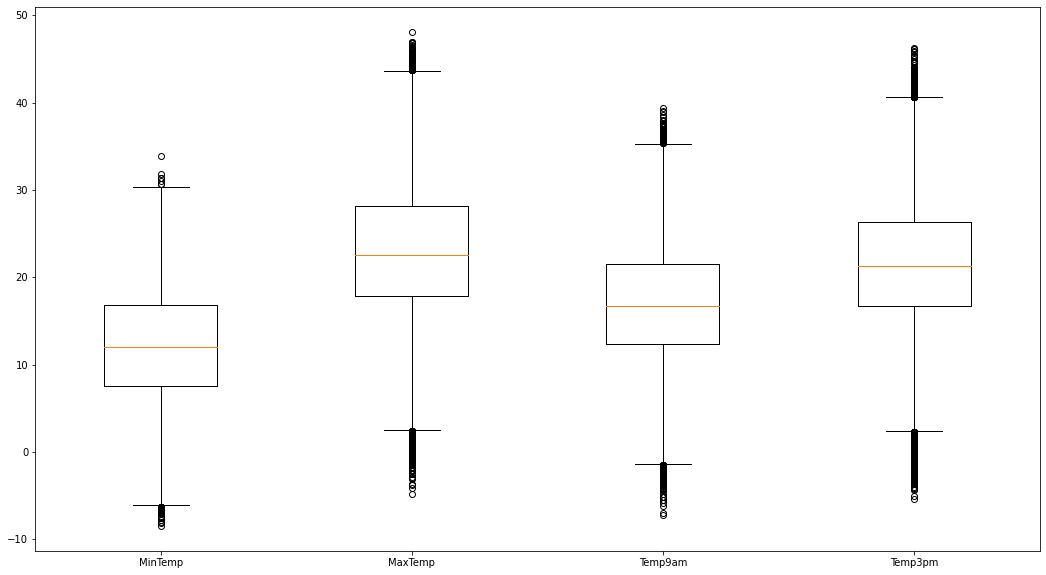

In [30]:
plt.figure(figsize=(18,10))
plt.boxplot(X_train[['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']].values, labels=['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm'])
plt.show()

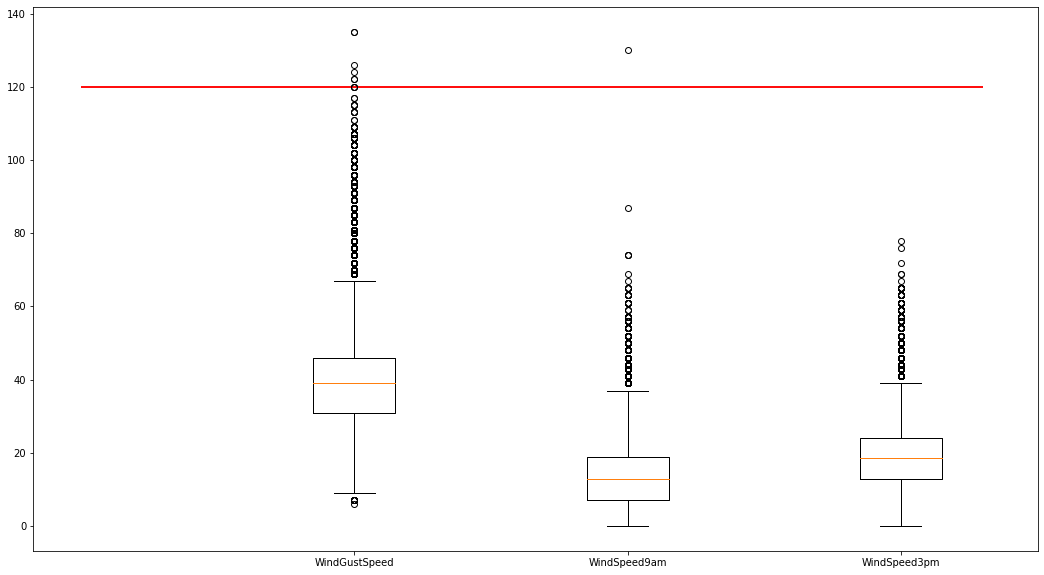

In [31]:
plt.figure(figsize=(18,10))
plt.boxplot(X_train[['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']].values, labels=['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm'])
plt.hlines([120,120], 0, 3.3, color='r')
plt.show()

In [32]:
X = pd.concat([X_train, y_train],axis=1) # Merge feature matrix and label

# Remove outliers
X = X[X['WindGustSpeed'] < 120]
X = X[X['WindSpeed9am'] < 120]

X_train = X.iloc[:, :-1]
y_train = X.iloc[:, -1]

X_train

,Climate,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,month
0,Hot dry summer cool winter,1.4,14.500000,1.8,5.474110,7.621462,SW,39.0,SW,SW,...,83.000000,44.00000,1022.900024,1022.599976,7.0,6.0,9.200000,13.000000,Yes,6
1,Warm temperate,6.3,15.400000,0.6,5.474110,7.621462,SSW,35.0,WSW,SW,...,68.839058,51.49173,1031.500000,1030.599976,7.0,7.0,11.600000,12.300000,No,7
2,Hot dry summer warm winter,6.3,25.000000,0.0,3.000000,7.621462,NW,30.0,NW,WNW,...,50.000000,18.00000,1015.500000,1012.000000,4.0,2.0,14.800000,24.299999,No,6
3,Cool temperate,6.5,14.000000,1.4,5.474110,7.621462,WNW,96.0,WNW,NW,...,68.000000,77.00000,1006.099976,1003.700012,8.0,8.0,8.700000,12.100000,Yes,10
4,Warm temperate,12.2,29.500000,0.0,6.000000,11.500000,NNE,28.0,E,E,...,46.000000,25.00000,1023.299988,1018.599976,0.0,1.0,19.200001,28.900000,No,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99530,Warm temperate,7.1,13.300000,0.0,10.000000,7.621462,NW,50.0,NW,WNW,...,74.000000,57.00000,1016.099976,1013.599976,8.0,8.0,8.500000,11.500000,No,6
99531,Hot dry summer cool winter,20.0,35.799999,0.0,5.474110,7.621462,NNE,39.0,ESE,NNE,...,49.000000,33.00000,1020.099976,1016.000000,7.0,7.0,24.900000,33.599998,No,2
99532,Mild temperate,9.5,18.299999,0.0,5.474110,7.621462,SSE,33.0,E,SSE,...,65.000000,58.00000,1018.000000,1015.099976,7.0,7.0,15.900000,17.000000,No,11
99533,Warm temperate,17.0,33.200001,0.0,16.799999,7.621462,WNW,93.0,WNW,WNW,...,62.000000,43.00000,1006.500000,1005.400024,4.0,6.0,23.900000,25.700001,No,3


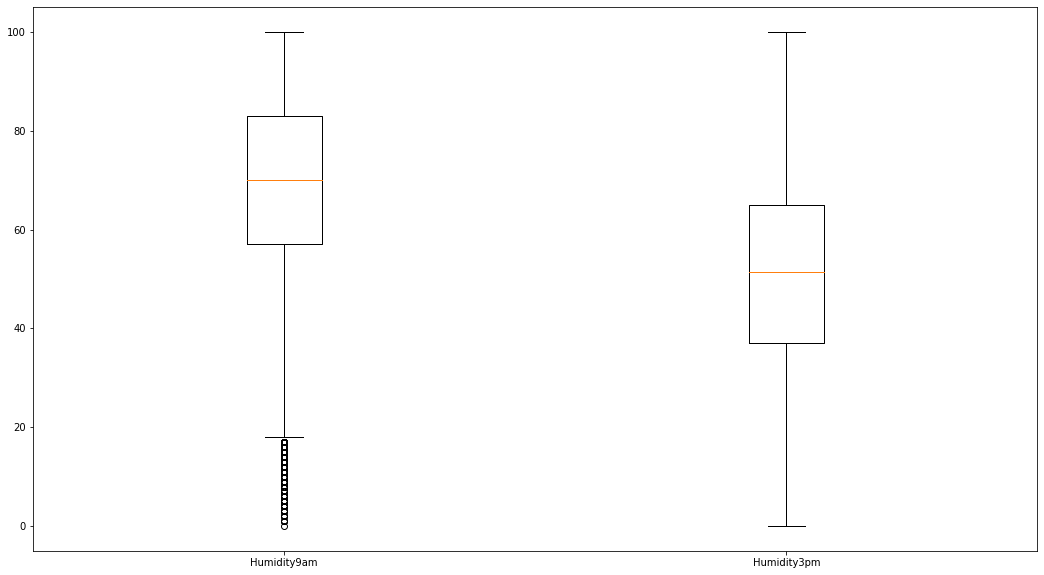

In [33]:
plt.figure(figsize=(18,10))
plt.boxplot(X_train[['Humidity9am','Humidity3pm']].values, labels=['Humidity9am','Humidity3pm'])
plt.show()

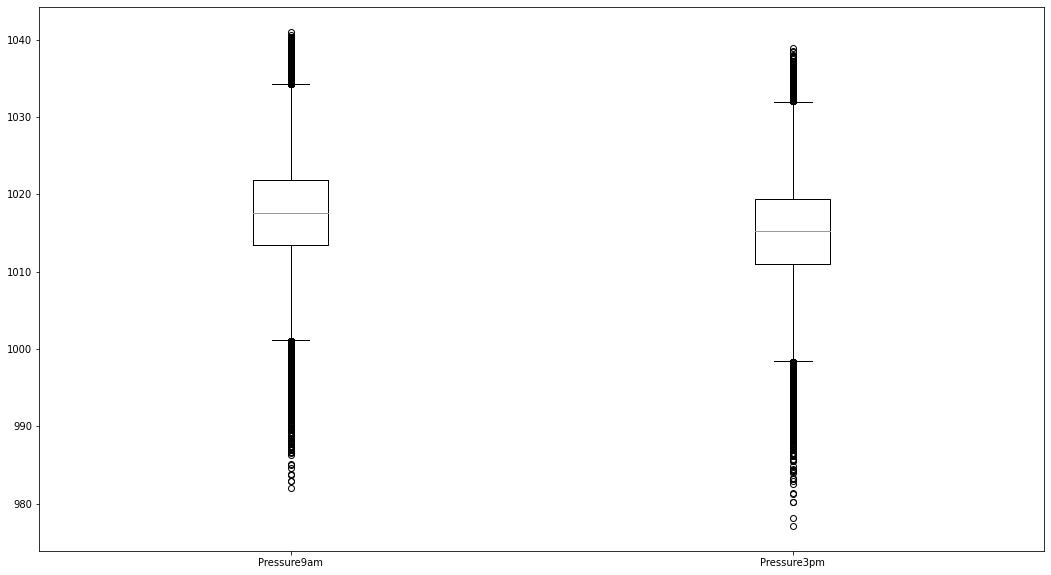

In [34]:
plt.figure(figsize=(18,10))
plt.boxplot(X_train[['Pressure9am','Pressure3pm']].values, labels=['Pressure9am','Pressure3pm'])
plt.show()

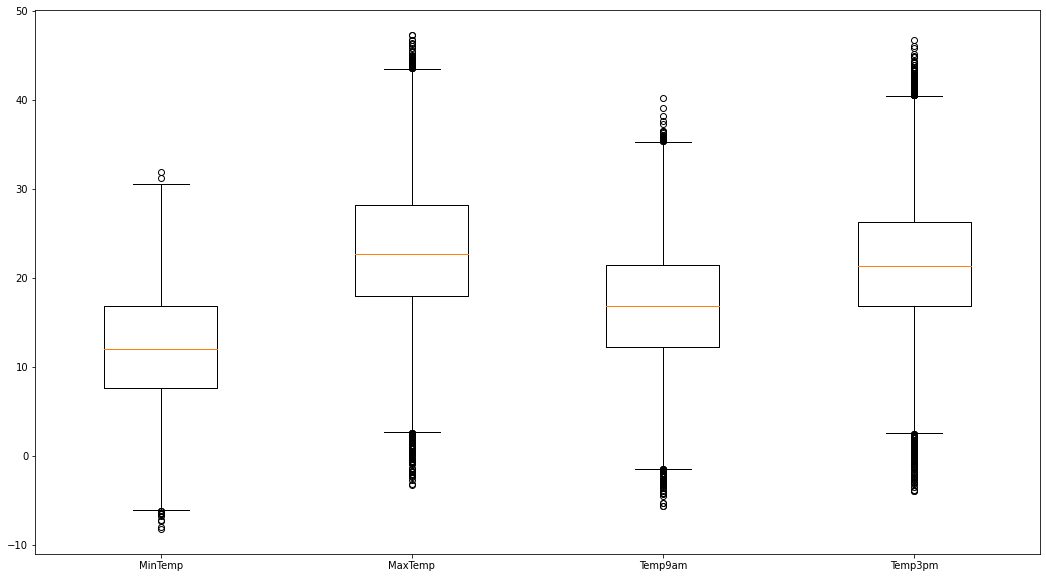

In [35]:
plt.figure(figsize=(18,10))
plt.boxplot(X_test[['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']].values, labels=['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm'])
plt.show()

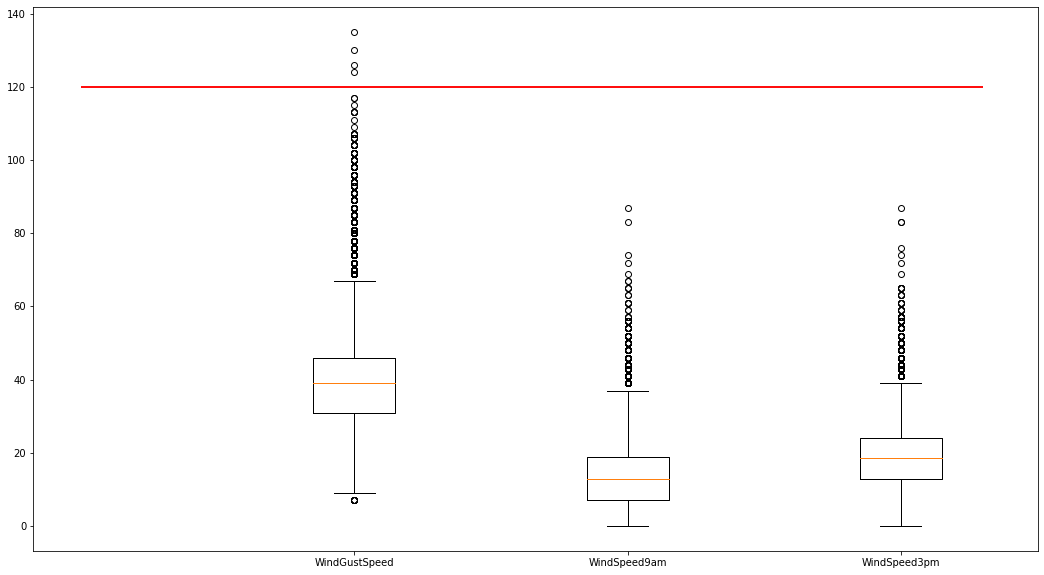

In [36]:
plt.figure(figsize=(18,10))
plt.boxplot(X_test[['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']].values, labels=['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm'])
plt.hlines([120,120], 0, 3.3, color='r')
plt.show()

In [37]:
X = pd.concat([X_test, y_test],axis=1) 

X = X[X['WindGustSpeed'] < 120]

X_test = X.iloc[:, :-1]
y_test = X.iloc[:, -1]

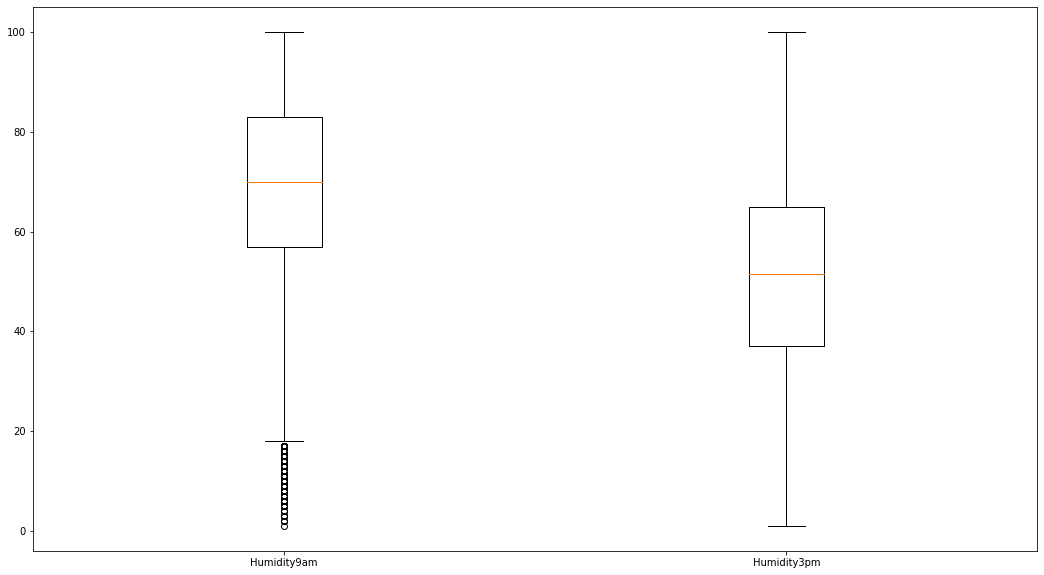

In [38]:
plt.figure(figsize=(18,10))
plt.boxplot(X_test[['Humidity9am','Humidity3pm']].values, labels=['Humidity9am','Humidity3pm'])
plt.show()

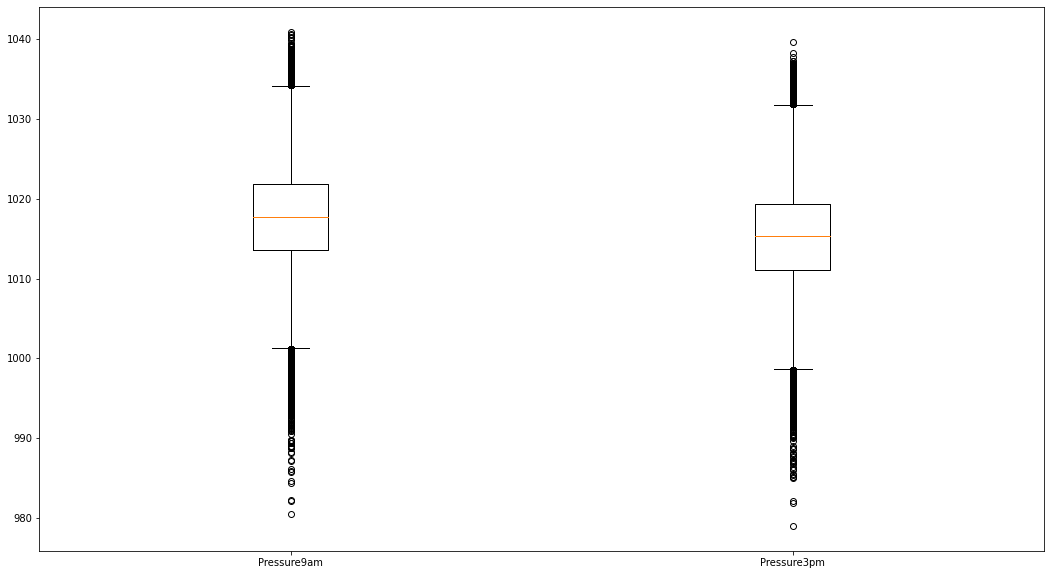

In [39]:
plt.figure(figsize=(18,10))
plt.boxplot(X_test[['Pressure9am','Pressure3pm']].values, labels=['Pressure9am','Pressure3pm'])
# plt.hlines([250,250], 0, 10, color='r')
plt.show()

In [40]:
# Recover Index
for i in [X_train, X_test, y_train, y_test]:
    i.index = range(i.shape[0])

## Analyze feature correlation by Correlation Matrix

In [41]:
categorical_cols = categorical_cols + ['month']
numerical_cols.remove('month')

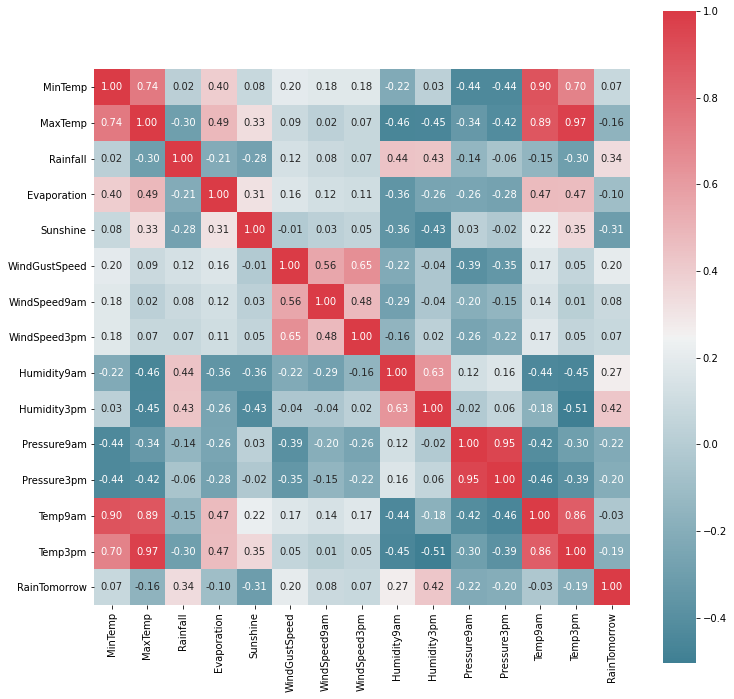

In [42]:
df2 = pd.DataFrame(y_train)
df2.rename(columns={0:'RainTomorrow'}, inplace=True)
cor_df = pd.concat([X_train.loc[:, numerical_cols], df2], axis=1)


plt.figure(figsize=(12,12))
column = cor_df.columns.tolist()
mcorr = cor_df[column].corr(method="spearman")  # Correlation Matrix

cmap = sns.diverging_palette(220, 10, as_cmap=True)
g = sns.heatmap(mcorr, cmap=cmap, square=True, annot=True, fmt='0.2f')
plt.show()

Arrange numerical features in descending order of relevance, and filter out features with label relevance less than 0.1

**Less than 0.1 means poor correlation**

In [43]:
mcorr = mcorr.abs()
numerical_corr = mcorr['RainTomorrow']  
print(numerical_corr.sort_values(ascending=False))

RainTomorrow     1.000000
Humidity3pm      0.424355
Rainfall         0.337584
Sunshine         0.309823
Humidity9am      0.265068
Pressure9am      0.219323
WindGustSpeed    0.203799
Pressure3pm      0.200186
Temp3pm          0.194392
MaxTemp          0.162989
Evaporation      0.099650
WindSpeed9am     0.082486
WindSpeed3pm     0.074529
MinTemp          0.072110
Temp9am          0.034923
Name: RainTomorrow, dtype: float64


In [44]:
# compress data
X_train[X_train.select_dtypes(np.float64).columns] = X_train.select_dtypes(np.float64).astype(np.float32)

## Correlation analysis of categorical features

In [45]:
# Climate	WindGustDir	WindDir9am	WindDir3pm	RainToday	Cloud9am	Cloud3pm month

In [46]:
X = pd.concat([X_train, df2], axis=1)
X[['Climate', 'RainTomorrow']].groupby(['Climate'], as_index=False).mean().sort_values(by='RainTomorrow', ascending=False)

,Climate,RainTomorrow
5,Mild temperate,0.280776
6,Warm humid summer mild winter,0.259719
1,High humidity summer warm winter,0.242641
0,Cool temperate,0.233817
7,Warm temperate,0.220831
4,MelbourneAirport,0.216981
2,Hot dry summer cool winter,0.172883
3,Hot dry summer warm winter,0.098756


The correlation with climate is not high

In [47]:
X[['RainToday', 'RainTomorrow']].groupby(['RainToday'], as_index=False).mean().sort_values(by='RainTomorrow', ascending=False)

,RainToday,RainTomorrow
1,Yes,0.465730
0,No,0.155997


There is a strong correlation between "RainToday" and "RainTomorrow".

It's also easy to understand. It usually rains for several days

In [48]:
X[['WindGustDir', 'RainTomorrow']].groupby(['WindGustDir'], as_index=False).mean().sort_values(by='RainTomorrow', ascending=False)

,WindGustDir,RainTomorrow
6,NNW,0.286511
7,NW,0.284625
14,WNW,0.280246
3,N,0.274725
13,W,0.267497
15,WSW,0.237670
5,NNE,0.231276
11,SSW,0.224170
8,S,0.224099
12,SW,0.205049


Poor correlation with "WindGustDir"

### 

In [49]:
X[['WindDir9am', 'RainTomorrow']].groupby(['WindDir9am'], as_index=False).mean().sort_values(by='RainTomorrow', ascending=False)

,WindDir9am,RainTomorrow
6,NNW,0.303970
7,NW,0.283328
5,NNE,0.271827
14,WNW,0.268432
13,W,0.266295
3,N,0.254507
15,WSW,0.247184
12,SW,0.233535
11,SSW,0.220171
4,NE,0.206394


Poor correlation with "WindDir9am" and WindDir3pm""

In [50]:
X[['Cloud9am', 'RainTomorrow']].groupby(['Cloud9am'], as_index=False).mean().sort_values(by='RainTomorrow', ascending=False)

,Cloud9am,RainTomorrow
8,8.0,0.456026
6,6.0,0.263045
7,7.0,0.242257
5,5.0,0.216741
4,4.0,0.204361
3,3.0,0.164293
2,2.0,0.137969
1,1.0,0.082739
0,0.0,0.028557


High correlation with "Cloud9am" and "Cloud3pm"

It has poor correlation with "month" after analysis, but it seems to have something to do with the season.

**I decide to convert the "month" into "Season" (It really has a better effect, after many experiments)**

In [51]:
X[['month', 'RainTomorrow']].groupby(['month'], as_index=False).mean().sort_values(by='RainTomorrow', ascending=False)

,month,RainTomorrow
6,7,0.269226
5,6,0.265712
7,8,0.254907
8,9,0.231913
4,5,0.227063
3,4,0.219899
10,11,0.212449
2,3,0.210859
1,2,0.210793
11,12,0.206698


In [52]:
month2season = {
    9 : "Spring",
    10 : "Spring",
    11 : "Spring",
    12 : "Summer",
    1 : "Summer",
    2 : "Summer",
    3 : "Autumn",
    4 : "Autumn",
    5 : "Autumn",
    6 : "Winter",
    7 : "Winter",
    8 : "Winter" 
}

In [53]:
X_train['month'] = X_train['month'].replace(month2season) # map里传入实现数值替换为对应的字符串
X_test['month'] = X_test['month'].replace(month2season)   # map里传入实现数值替换为对应的字符串

X_train.rename(columns={'month':'Season'}, inplace=True)
X_test.rename(columns={'month':'Season'}, inplace=True)

In [54]:
X = pd.concat([X_train, df2], axis=1)
X[['Season', 'RainTomorrow']].groupby(['Season'], as_index=False).mean().sort_values(by='RainTomorrow', ascending=False)

,Season,RainTomorrow
3,Winter,0.263315
0,Autumn,0.219225
1,Spring,0.213442
2,Summer,0.201530


In [55]:
categorical_cols[-1] = "Season"
categorical_cols

['Climate',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'Cloud9am',
 'Cloud3pm',
 'Season']

## Encode categorical features using OrdinalEncoder

The second category is 0, 1; Multi classification is dummy variable

In [56]:
# Binary classification will be encoded to 0 and 1;
# Multi-classification will be encoded to Dummy variable
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()

oe = oe.fit(X_train.loc[:, categorical_cols])

# Use _transfer() to avoid the categories not in the training set, but in the test set
X_train.loc[:, categorical_cols] = oe.transform(X_train.loc[:, categorical_cols])
X_test.loc[:, categorical_cols] = oe._transform(X_test.loc[:, categorical_cols], handle_unknown='ignore')[0].astype(np.float32, copy=False)

In [57]:
X_test.loc[:, categorical_cols].head()

,Climate,WindGustDir,WindDir9am,WindDir3pm,RainToday,Cloud9am,Cloud3pm,Season
0,7.0,1.0,1.0,0.0,0.0,1.0,1.0,3.0
1,7.0,13.0,7.0,9.0,1.0,1.0,5.0,2.0
2,7.0,15.0,12.0,15.0,0.0,8.0,7.0,1.0
3,0.0,8.0,8.0,10.0,0.0,7.0,7.0,3.0
4,5.0,6.0,3.0,7.0,0.0,7.0,7.0,2.0


## Discard features with poor correlation

They may have a negative impact on classification results

In [58]:
to_drop = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Climate', 'Evaporation', 'WindSpeed9am', 'WindSpeed3pm', 'MinTemp', 'Temp9am']

X_train.drop(to_drop, inplace=True, axis=1)
X_test.drop(to_drop, inplace=True, axis=1)

X_train

,MaxTemp,Rainfall,Sunshine,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp3pm,RainToday,Season
0,14.500000,1.8,7.621462,39.0,83.000000,44.00000,1022.900024,1022.599976,7.0,6.0,13.000000,1.0,3.0
1,15.400000,0.6,7.621462,35.0,68.839058,51.49173,1031.500000,1030.599976,7.0,7.0,12.300000,0.0,3.0
2,25.000000,0.0,7.621462,30.0,50.000000,18.00000,1015.500000,1012.000000,4.0,2.0,24.299999,0.0,3.0
3,14.000000,1.4,7.621462,96.0,68.000000,77.00000,1006.099976,1003.700012,8.0,8.0,12.100000,1.0,1.0
4,29.500000,0.0,11.500000,28.0,46.000000,25.00000,1023.299988,1018.599976,0.0,1.0,28.900000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99520,13.300000,0.0,7.621462,50.0,74.000000,57.00000,1016.099976,1013.599976,8.0,8.0,11.500000,0.0,3.0
99521,35.799999,0.0,7.621462,39.0,49.000000,33.00000,1020.099976,1016.000000,7.0,7.0,33.599998,0.0,2.0
99522,18.299999,0.0,7.621462,33.0,65.000000,58.00000,1018.000000,1015.099976,7.0,7.0,17.000000,0.0,1.0
99523,33.200001,0.0,7.621462,93.0,62.000000,43.00000,1006.500000,1005.400024,4.0,6.0,25.700001,0.0,0.0


# 4. Model and Predict

In [59]:
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_auc_score

In [60]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=666) # 把训练集划分成训练集和验证集

# Recover index
for i in [X_train, X_test, y_train, y_test, X_val, y_val]:
    i.index = range(i.shape[0])

## Data normalization for continuous features

I tried both "StandardScaler" and "MinMaxScaler", the result is **"StandardScaler" is better**.

1. Standardization better maintains sample spacing. "Australian Rain Data" has many extreme values and outliers, therefore, "MainMaxScaler" may compress the sample to the vicinity of outliers in this case.
2. Standardization is more consistent with statistical assumptions.
3. **The experimental results show that "StandardScaler" is about 0.07 higher than "MinMaxScaler" in the prediction score.**

In [61]:
numerical_cols = ["MaxTemp", "Rainfall", "Sunshine", "WindGustSpeed", "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm", "Temp3pm"]

In [62]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
scaler.fit(X_train.loc[:, numerical_cols])

X_train.loc[:, numerical_cols] = scaler.transform(X_train.loc[:, numerical_cols])
X_val.loc[:, numerical_cols] = scaler.transform(X_val.loc[:, numerical_cols])
X_test.loc[:, numerical_cols] = scaler.transform(X_test.loc[:, numerical_cols])

display(X_train.head(10))
display(X_val.head())
display(X_test.head())

,MaxTemp,Rainfall,Sunshine,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp3pm,RainToday,Season
0,-1.083755,-0.279168,0.000725,-0.911788,1.642854,0.656772,0.509941,0.275676,8.0,7.0,-1.013444,0.0,0.0
1,-0.017024,0.339949,1.961906,0.461038,-0.627132,-0.998349,-0.837350,-0.740920,0.0,1.0,-0.025887,1.0,2.0
2,0.404054,-0.207731,0.000725,1.223719,1.378902,-1.047029,0.287859,-0.187770,7.0,7.0,0.569551,0.0,1.0
3,0.712845,-0.279168,1.159718,0.308501,0.059143,-0.803629,-1.089044,-1.473463,1.0,5.0,0.860009,0.0,2.0
4,-0.662677,-0.279168,-2.377200,-0.530448,-0.257599,1.630373,0.598779,0.395283,7.0,7.0,-0.693940,0.0,3.0
5,0.235623,-0.255356,2.144221,0.079697,-0.891083,0.510732,-1.799703,-2.086418,7.0,7.0,-0.200162,0.0,2.0
6,0.291767,-0.279168,-0.262342,1.299987,-1.207826,-1.436469,0.184228,0.021533,8.0,5.0,0.467891,0.0,1.0
7,-0.620569,-0.279168,0.000725,-1.216861,1.431692,-0.560229,0.006562,0.021533,7.0,7.0,-0.461574,0.0,3.0
8,-1.083755,-0.279168,0.000725,-0.377912,0.217514,-1.290429,2.123736,2.084618,7.0,7.0,-0.911784,0.0,3.0
9,-1.055683,-0.279168,-0.225879,0.079697,1.590064,-0.316829,1.427888,1.337120,7.0,3.0,-0.984398,0.0,3.0


,MaxTemp,Rainfall,Sunshine,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp3pm,RainToday,Season
0,-0.774964,-0.279168,0.102289,0.079697,-0.310389,-0.365509,-0.511629,-0.456867,0.0,4.0,-0.737509,0.0,3.0
1,-1.111827,-0.279168,-2.632442,-0.682984,0.270305,1.289613,-2.362307,-2.101364,5.0,7.0,-0.940830,0.0,3.0
2,1.246210,-0.279168,0.000725,1.299987,-2.474794,-2.069310,0.361886,0.111230,0.0,7.0,1.426402,0.0,1.0
3,1.119887,-0.279168,1.816054,0.766110,-0.891083,-1.387789,-0.052664,0.096283,2.0,3.0,1.281173,0.0,2.0
4,0.726881,1.054316,-2.413663,0.003829,1.326112,0.267332,-0.008249,0.111230,8.0,7.0,0.889055,1.0,1.0


,MaxTemp,Rainfall,Sunshine,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp3pm,RainToday,Season
0,-0.480210,-0.279168,0.576309,0.766110,0.006353,-0.365509,1.546321,1.516531,1.0,1.0,-0.330868,0.0,3.0
1,1.597109,-0.112482,0.004849,-0.001511,0.692627,-0.024748,0.003823,0.005757,1.0,5.0,1.237605,1.0,2.0
2,0.797060,-0.279168,-1.356234,-0.225375,-0.785503,-0.073428,-0.348772,0.051426,8.0,7.0,0.511460,0.0,1.0
3,-0.774964,-0.279168,0.004849,0.613574,-0.257599,1.289613,1.205807,1.127826,7.0,7.0,-0.839169,0.0,3.0
4,2.425229,-0.279168,1.597275,1.223719,-1.999681,-1.777230,-0.541241,-0.591421,7.0,7.0,2.515619,0.0,2.0


Because the sample has a slight imbalance problem, I printed the **confusion matrix** of all models on the validation set to ensure the reliability of the model.

Five basic models suitable for classification tasks are tested respectively。
1. Decision Tree
2. Naive Bayesian
3. K-Nearest Neighbor
4. Support Vector Machine
5. Logistic Regression

### （1）Decision Tree

Decision Tree is the most effective way to solve the classification problem.I chose the decision tree because it has many advantages：

1. The calculation complexity is not high, the output results are easy to understand and can be explained
2. Insensitive to the absence of intermediate values
3. Can handle irrelevant features and data

In [63]:
from sklearn.tree import DecisionTreeClassifier 

cat_tree = DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=42)
cat_tree.fit(X_train, y_train)
pred_tree = cat_tree.predict(X_val)

print(classification_report(y_true=y_val, y_pred=pred_tree))

              precision    recall  f1-score   support

           0       0.86      0.96      0.90     19253
           1       0.75      0.45      0.56      5629

    accuracy                           0.84     24882
   macro avg       0.80      0.70      0.73     24882
weighted avg       0.83      0.84      0.83     24882



In [64]:
# param_grid = [
#     {
#         'criterion': ['entropy'], 
#         'max_depth': [i for i in range(4, 15)]
#     },
#     {
#         'criterion': ['gini'],
#         'max_depth': [i for i in range(4, 15)], 
#     }
# ]


# cat_tree = DecisionTreeClassifier(criterion='entropy', random_state=42)


# from sklearn.model_selection import GridSearchCV

# grid_search = GridSearchCV(cat_tree, param_grid, n_jobs=-1, verbose=2)

In [65]:
# %%time
# grid_search.fit(X_train, y_train)

In [66]:
# print("Best score:{:.2f}".format(grid_search.score(X_val, y_val)))          
# print("Best parameters:{}".format(grid_search.best_params_))    

# Best score:0.84
# Best parameters:{'criterion': 'gini', 'max_depth': 7}

I use Grid Search in sklearn to find the best Hyperparameters. "Criterion" from "entropy" to "gini", "max_depth" from "4" to "14"

The result is that the Best parameters is **{'criterion': 'gini', 'max_depth': 7}**

I commented it out because it took too long (See above)

### （2）Naive Bayes

I choose Naive Bayesian because that it has a solid mathematical foundation and stable classification efficiency. It can calculate the probability to get the classification result, and even could solve the multi classification problem. **"RainTomorrow" is a binary classification problem, and Bernoulli distribution is also binomial distribution**, so I tried.

1. It can handle multi classification problems by calculating probability
2. It is not too sensitive to missing data, and the algorithm is relatively simple, which is often used for text classification.

In [67]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
pred_gnb = gnb.predict(X_val)

print(classification_report(y_true=y_val, y_pred=pred_gnb))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     19253
           1       0.56      0.61      0.58      5629

    accuracy                           0.80     24882
   macro avg       0.72      0.73      0.73     24882
weighted avg       0.81      0.80      0.81     24882



I have tried GaussianNB and BernoulliNB.

**The result is GaussianNB performs better, but that confused me. I always think BernoulliNB is better for binary classification.**

### （3）kNN

The reason why I try kNN is because it is the **simplest**, and **easy to tune hyperparameters** in order to get best classifier.

1. Simple, high precision, mature theory, which can be used for both classification and regression
2. It can be used for numerical data and discrete data;
3. The training time complexity is O(n);
4. No data input assumption;
5. Not sensitive to outliers

In [68]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(p=1, n_neighbors=9)
knn_clf.fit(X_train, y_train)
pred_clf = knn_clf.predict(X_val)

print(classification_report(y_true=y_val, y_pred=pred_clf))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     19253
           1       0.72      0.47      0.57      5629

    accuracy                           0.84     24882
   macro avg       0.79      0.71      0.73     24882
weighted avg       0.83      0.84      0.82     24882



In [69]:
# best_score = 0

# for weight in ['uniform', 'distance']:
#     for n in range(1,12):
#         for p in range(1,5):  
#             knn_clf = KNeighborsClassifier(n_neighbors=n, p=p,weights=weight, n_jobs=-1)#对于每种参数可能的组合，进行一次训练；
#             knn_clf.fit(X_train,y_train)
#             score = knn_clf.score(X_val, y_val)
#             if score > best_score: # 找到表现最好的参数
#                 best_score = score
#                 best_parameters = {'p':p, 'n_neighbors':n, 'weight':weight}

# print("Best score:{:.2f}".format(best_score))            
# print("Best parameters:{}".format(best_parameters))      

# Best score:0.84
# Best parameters:{'p': 1, 'n_neighbors': 9, 'weight': 'uniform'}

I use Grid Search to find the best Hyperparameters. "weight" from "uniform" to "distance", "n_neighbors" from "1" to "11", "p" from "1" to "4".

The result is that the Best parameters is **{'p': 1, 'n_neighbors': 9, 'weight': 'uniform'}**

I commented it out because it took too long (See above)

### （4）SVM 

SVM has many advantages:

1. It has good learning ability, and the learned results have good generalization.
2. SVM has a low error rate and can make good classification decisions for data points outside the training set
3. The best ready available classifier, sometimes it can be used directly without modification.

In [70]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

svc = LinearSVC(max_iter=5000)
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_val)

print(classification_report(y_true=y_val, y_pred=pred_svc))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     19253
           1       0.73      0.46      0.57      5629

    accuracy                           0.84     24882
   macro avg       0.80      0.71      0.73     24882
weighted avg       0.83      0.84      0.83     24882



c:\users\asus\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### （5）Logistic Regression

I choose Logistic Regression is because:

1. Model training is fast and **suitable for binary classification problems**
2. Simple and easy to understand, high interpretability 

In [71]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
pred_log_reg = log_reg.predict(X_val)

print(classification_report(y_true=y_val, y_pred=pred_log_reg))  

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     19253
           1       0.72      0.49      0.58      5629

    accuracy                           0.84     24882
   macro avg       0.79      0.72      0.74     24882
weighted avg       0.83      0.84      0.83     24882



## Draw ROC curve

c:\users\asus\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
c:\users\asus\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
c:\users\asus\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plo

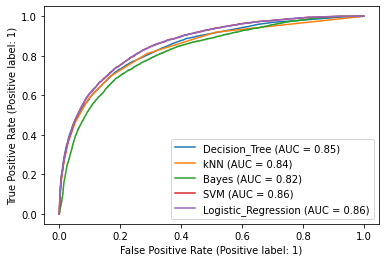

In [72]:
ax = plt.gca()
plot_tree = plot_roc_curve(estimator=cat_tree, X=X_val, y=y_val, ax=ax, name='Decision_Tree')
plot_kNN = plot_roc_curve(estimator=knn_clf, X=X_val, y=y_val, ax=ax, name='kNN')
plot_bayes = plot_roc_curve(estimator=gnb, X=X_val, y=y_val, ax=ax, name='Bayes')
plot_svm = plot_roc_curve(estimator=svc, X=X_val, y=y_val, ax=ax, name='SVM')
plot_log = plot_roc_curve(estimator=log_reg, X=X_val, y=y_val, ax=ax, name='Logistic_Regression')

The higher the AUC value, the better the classifier.

Logistics Regression = SVM > Decision Tree > kNN > Bayes

## Cross-Validation

In [73]:
from sklearn.model_selection import cross_val_score

In [74]:
# Logistic Regression
scores = cross_val_score(estimator=log_reg, X=X_val, y=y_val.values.ravel(), cv=10, scoring='f1_macro')
print('F1_score: %0.2f std: %0.2f'%(scores.mean(), scores.std()))
#F1_score: 0.74 std: 0.01

F1_score: 0.74 std: 0.01


In [75]:
# SVM
scores = cross_val_score(estimator=svc, X=X_val, y=y_val.values.ravel(), cv=10, scoring='f1_macro')
print('F1_score: %0.2f std: %0.2f'%(scores.mean(), scores.std()))  
# F1_score: 0.74 std: 0.01

c:\users\asus\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\asus\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\asus\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\asus\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\users\asus\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  

F1_score: 0.74 std: 0.01


c:\users\asus\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [76]:
# Decision_Tree
scores = cross_val_score(estimator=cat_tree, X=X_val, y=y_val.values.ravel(), cv=10, scoring='f1_macro')
print('F1_score: %0.2f std: %0.2f'%(scores.mean(), scores.std()))
# F1_score: 0.73 std: 0.01

F1_score: 0.73 std: 0.01


In [77]:
# kNN
scores = cross_val_score(estimator=knn_clf, X=X_val, y=y_val.values.ravel(), cv=10, scoring='f1_macro')
print('F1_score: %0.2f std: %0.2f'%(scores.mean(), scores.std()))
# F1_score: 0.73 std: 0.01

F1_score: 0.73 std: 0.01


In [78]:
# Bayes
scores = cross_val_score(estimator=gnb, X=X_val, y=y_val.values.ravel(), cv=10, scoring='f1_macro')
print('F1_score: %0.2f std: %0.2f'%(scores.mean(), scores.std()))
# F1_score: 0.73 std: 0.01

F1_score: 0.73 std: 0.01


# 5.Ensembles

I used 4 ensemble method, Bagging, Random Forest, Voting Classifier and Boosting respectively.

And finally the **Gradient Boosting** performs better.

In [79]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier, GradientBoostingClassifier

## Bagging

In [80]:
bag_clf = BaggingClassifier(base_estimator=log_reg, n_estimators=200)

bag_clf.fit(X_train, y_train.values.ravel())

BaggingClassifier(base_estimator=LogisticRegression(max_iter=1000,
                                                    random_state=42),
                  n_estimators=200)

In [81]:
pred = bag_clf.predict(X_test)
print(classification_report(y_pred=pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     33148
           1       0.72      0.48      0.58      9506

    accuracy                           0.84     42654
   macro avg       0.79      0.71      0.74     42654
weighted avg       0.83      0.84      0.83     42654



## Random Forest

In [82]:
rf_clf = RandomForestClassifier(n_estimators=200, random_state=666, max_depth=2)

rf_clf.fit(X_train, y_train.values.ravel())

pred = rf_clf.predict(X_val)
print(classification_report(y_pred=pred, y_true=y_val))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     19253
           1       0.84      0.18      0.30      5629

    accuracy                           0.81     24882
   macro avg       0.82      0.59      0.59     24882
weighted avg       0.81      0.81      0.76     24882



## Voting classifier

In [83]:
voting_clf = VotingClassifier(estimators=[
    ('decTree', cat_tree),
    ('LogReg', log_reg),
    ('SVM', svc),
    ('kNN', knn_clf),
    ('Bayes', gnb),
], voting='hard')

voting_clf.fit(X_train, y_train.values.ravel())

pred = voting_clf.predict(X_val)
print(classification_report(y_pred=pred, y_true=y_val))

c:\users\asus\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.86      0.95      0.90     19253
           1       0.74      0.49      0.59      5629

    accuracy                           0.84     24882
   macro avg       0.80      0.72      0.75     24882
weighted avg       0.83      0.84      0.83     24882



More reasonable voting should have weight, so the Soft Voting Classifier also tried.

In [84]:
# voting_clf2 = VotingClassifier(estimators=[
#     ('decTree', cat_tree),
#     ('LogReg', log_reg),
#     ('SVM', SVC(probability=True)),
#     ('kNN', knn_clf),
#     ('Bayes', gnb),
# ], voting='soft')

# voting_clf2.fit(X_train, y_train.values.ravel())

# pred = voting_clf2.predict(X_val)
# print(classification_report(y_pred=pred, y_true=y_val))

## Boosting

In [85]:
gb_clf = GradientBoostingClassifier(n_estimators=200)
gb_clf.fit(X_train, y_train.values.ravel())

pred = gb_clf.predict(X_val)
print(classification_report(y_pred=pred, y_true=y_val))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     19253
           1       0.74      0.52      0.61      5629

    accuracy                           0.85     24882
   macro avg       0.81      0.74      0.76     24882
weighted avg       0.84      0.85      0.84     24882



c:\users\asus\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
c:\users\asus\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
c:\users\asus\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plo

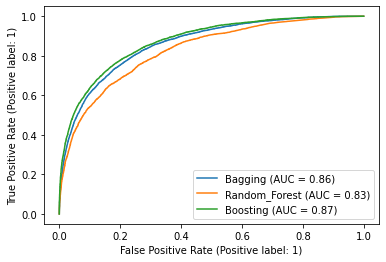

In [86]:
ax = plt.gca()
plot_bagging = plot_roc_curve(estimator=bag_clf, X=X_val, y=y_val, ax=ax, name='Bagging')
plot_rf_clf = plot_roc_curve(estimator=rf_clf, X=X_val, y=y_val, ax=ax, name='Random_Forest')
plot_gb_clf = plot_roc_curve(estimator=gb_clf, X=X_val, y=y_val, ax=ax, name='Boosting')

After the above cross validation and ROC curve drawing,

Boosting > Bagging > Voting Classifier > Random Forest

**the final conclusion is that Gradient Boosting has the best effect**

# 6.Final step is to test our model against the test dataset.

In [87]:
pred = gb_clf.predict(X_test)
print(classification_report(y_true=y_test, y_pred=pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     33148
           1       0.74      0.50      0.60      9506

    accuracy                           0.85     42654
   macro avg       0.80      0.73      0.75     42654
weighted avg       0.84      0.85      0.84     42654

